# Post-stack inversion with proximal solvers - Hess model (with partial knowledge)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')
import collections

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import segyio

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.basicoperators import VStack as VStacklop


from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

from htracker.jointinv import joint_inversion_segmentation
from htracker.workflows import *

np.random.seed(10)

plt.style.use('seaborn-ticks')
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)

In [2]:
os.environ['NUMBA_NUM_THREADS'] = '6'

In [3]:
def callback(x, xhist):
    xhist.append(x)

In [4]:
def RRE(x, xinv):
    return np.linalg.norm(x-xinv) / np.linalg.norm(x)

In [5]:
def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv) / np.linalg.norm(x-xinv))

In [6]:
rre = {}
psnr = {}

## Hess model

In [7]:
f = segyio.open('../data/timodel_vp.segy', ignore_geometry=True)
v = segyio.collect(f.trace[:]).T
v = np.pad(v, ((80, 0), (0, 0)), constant_values=v[0, 0])
v = v[::8, ::8]

nt0, nx = v.shape
dt0 = 0.008
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

rho = 2000.
m = np.log(v*rho)

Identify classes

In [8]:
collections.Counter(m[:nt0-60, 3*nx//4])

Counter({16.118093: 23,
         16.198013: 8,
         16.360882: 9,
         16.448978: 17,
         16.60986: 23,
         16.705547: 18,
         16.767603: 9,
         16.853342: 31})

In [9]:
allclall = np.unique(m)
nclmin = 3000
print(allclall)

clall = np.array(list(filter(lambda x: np.count_nonzero(m.ravel() == x) > nclmin, allclall)))
nclall = len(clall)
print(len(allclall), nclall)

vcl_trueall = np.zeros_like(m)
for icl in range(nclall):
    vcl_trueall[m == clall[icl]] = icl

[16.118093 16.198013 16.360882 16.448978 16.56278  16.60986  16.705547
 16.767603 16.853342 16.922604 16.983343 17.203283]
12 10


In [10]:
allcl = np.unique(m[:nt0-60, 3*nx//4])
allcl = np.append(allcl, m.max()) # add salt
print(allcl)
cl = np.array(list(filter(lambda x: np.count_nonzero(m.ravel() == x) > nclmin, allcl)))
ncl = len(cl)
print(len(allcl), ncl)

vcl_true = np.zeros_like(m) # force everything to be in the non-present class
for icl in range(ncl):
    vcl_true[m == cl[icl]] = icl
vcl_true[(m > allclall[7]) & (m < allclall[-1])] = 6

[16.118093 16.198013 16.360882 16.448978 16.60986  16.705547 16.767603
 16.853342 17.203283]
9 8


True horizons

In [11]:
hors = {}
for icl in range(ncl-1):
    mclass = (vcl_true == icl).astype(np.int)
    
    cabove = np.zeros(nx)
    cbelow = np.zeros(nx)
    hor = -1 * np.ones(nx)
    for ix in range(nx):
        it = np.where(np.diff(mclass[:, ix]) == -1)[0]
        if len(it) > 0:
            hor[ix] = it[0 if icl==0 else -1] # quick hack
            cabove[ix] = vcl_true[it[0 if icl==0 else -1] - 1, ix]
            cbelow[ix] = vcl_true[it[0 if icl==0 else -1] + 1, ix]
    cabove_sel = sp.stats.mode(cabove)[0]
    cbelow_sel = sp.stats.mode(cbelow)[0]
    
    mask = hor >= 0
    for ix in range(nx):
        if cabove[ix] != cabove_sel or cbelow[ix] != cbelow_sel:
            mask[ix] = False
    if np.sum(mask) > 0:
        hor = np.interp(np.arange(nx), np.arange(nx)[mask], hor[mask])
        hor[~mask] = np.nan
        hors['a%db%d' % (cabove_sel, cbelow_sel)] = hor

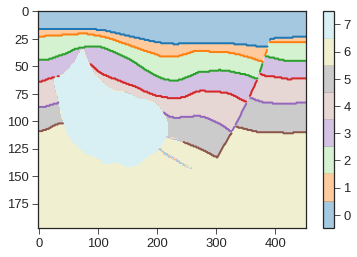

In [12]:
plt.figure()
plt.imshow(vcl_true.reshape(nt0, nx),
           cmap=cm.get_cmap('tab20', ncl), 
           vmin=-0.5, vmax=ncl-0.5, alpha=0.4)
plt.axis('tight')
for icl in list(hors.keys()):
    plt.plot(np.arange(nx), hors[icl], lw=2)
plt.colorbar();

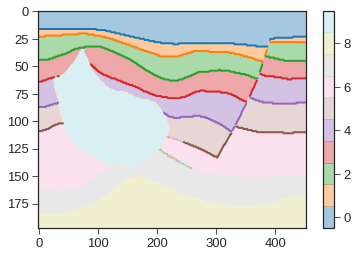

In [13]:
plt.figure()
plt.imshow(vcl_trueall.reshape(nt0, nx),
           cmap=cm.get_cmap('tab20', nclall), 
           vmin=-0.5, vmax=nclall-0.5, alpha=0.4)
plt.axis('tight')
for icl in list(hors.keys()):
    plt.plot(np.arange(nx), hors[icl], lw=2)
plt.colorbar();

Compute data

In [16]:
# smooth model
nsmooth = 30
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1,
                 filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0), axis=1)

# wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav//2+1], 8)

# operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
d = Lop * m.ravel()

# colored noise
sigman = 1e-1
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust').ravel()
dn = d + n

# background data
dback = Lop * mback.ravel()

d = d.reshape(nt0, nx)
dn = dn.reshape(nt0, nx)
dback = dback.reshape(nt0, nx)

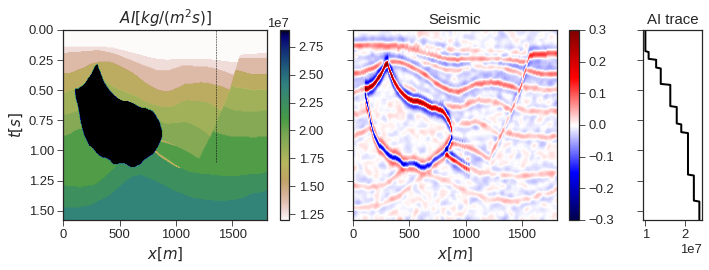

In [17]:
cmap='gist_earth_r'

fig, axs = plt.subplots(1, 3, sharey=True, 
                        gridspec_kw={'width_ratios': [3, 3, 0.7]}, figsize=(10, 4))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'$AI [kg/(m^2s)]$')
im = axs[1].imshow(dn, cmap='seismic', vmin=-0.3, vmax=0.3, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Seismic')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(np.exp(m[:, 3*nx//4]), t0, 'k', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace')
plt.tight_layout()
plt.savefig('Figs/Hesspartial_modeldata.eps', dpi=150);

## 2D Post-stack inversion

In [18]:
# L2 regularized inversion
Dop = Laplacian(dims=(nt0, nx), dtype=Lop.dtype)
minv = RegularizedInversion(Lop, [Dop], dn.ravel(),
                            x0=mback.ravel(), epsRs=[2.], returninfo=False, show=False,
                            **dict(iter_lim=100, damp=1e-4))
dinv = Lop*minv

minv = minv.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['L2'] = RRE(m.ravel(), minv.ravel())
psnr['L2'] = PSNR(m.ravel(), minv.ravel())
print('RRE=', rre['L2'])
print('PSNR=', psnr['L2'])

RRE= 0.002945034043801516
PSNR= 50.202946056904935


In [19]:
# SplitBregman (Blockiness-promoting inversion with anisotropic TV)
RegL1op = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
msb = SplitBregman(Lop, [RegL1op], dn.ravel(),
                   epsRL1s=[0.03], mu=0.3,
                   niter_outer=5,
                   niter_inner=10,
                   x0=mback.ravel(), show=True,
                   **dict(iter_lim=5, damp=1e-4))[0]
dinv = Lop*msb

msb = msb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['SB'] = RRE(m.ravel(), msb.ravel())
psnr['SB'] = PSNR(m.ravel(), msb.ravel())
print('RRE=', rre['SB'])
print('PSNR=', psnr['SB'])

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 89694 rows and 89694 cols
niter_outer =   5     niter_inner =  10   tol = 1.00e-10
mu = 3.00e-01         epsL1 = [0.03]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   1.61647e+01        3.163e-01        1.342e+03
     2   1.61653e+01        3.252e-01        1.194e+03
     3   1.61606e+01        3.437e-01        1.120e+03
     4   1.61627e+01        3.608e-01        1.074e+03
     5   1.61721e+01        3.737e-01        1.039e+03

Iterations = 5        Total time (s) = 4.91
---------------------------------------------------------

RRE= 0.0023869446620438358
PSNR= 51.111738205855985


In [20]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

sigma=0.04
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=10, warm=True)

# steps
L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

mladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=mback.ravel(), niter=100, show=True)[0]
dinv = Lop*mladmm

mladmm = mladmm.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['LADMM'] = RRE(m.ravel(), mladmm.ravel())
psnr['LADMM'] = PSNR(m.ravel(), mladmm.ravel())
print('RRE=', rre['LADMM'])
print('PSNR=', psnr['LADMM'])

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.237500e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   1.61181e+01   5.059e+01   2.122e+01   7.181e+01
     2   1.61194e+01   4.068e+01   2.192e+01   6.260e+01
     3   1.61215e+01   3.373e+01   2.273e+01   5.646e+01
     4   1.61244e+01   2.856e+01   2.351e+01   5.207e+01
     5   1.61278e+01   2.462e+01   2.422e+01   4.884e+01
     6   1.61315e+01   2.162e+01   2.479e+01   4.640e+01
     7   1.61351e+01   1.929e+01   2.526e+01   4.455e+01
     8   1.61382e+01   1.746e+01   2.565e+01   4.311e+01
     9   1.61408e+01   1.600e+01   2.595e+01   4.194e+01
    10   1.61430e+01   1.480e+01   2.616e+01   4.095e+01
    11   1.61450e+01   1.380e+01   2.630e+01   4.010e+01
    2

In [21]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, mback.ravel(), tau=tau, mu=mu, 
                 theta=1., niter=100, show=True)
dinv = Lop*mpd

mpd = mpd.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

rre['PD'] = RRE(m.ravel(), mpd.ravel())
psnr['PD'] = PSNR(m.ravel(), mpd.ravel())
print('RRE=', rre['PD'])
print('PSNR=', psnr['PD'])

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.237500e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.61196e+01   1.914e+01   6.993e+00   0.000e+00       2.614e+01
     2   1.61259e+01   9.430e+00   8.270e+00   0.000e+00       1.770e+01
     3   1.61337e+01   6.373e+00   8.728e+00   0.000e+00       1.510e+01
     4   1.61418e+01   5.003e+00   8.837e+00   0.000e+00       1.384e+01
     5   1.61492e+01   4.239e+00   8.808e+00   0.000e+00       1.305e+01
     6   1.61555e+01   3.757e+00   8.726e+00   0.000e+00       1.248e+01
     7   1.61605e+01   3.426e+00   8.654e+00   0.000e+00       1.208e+01
     8   1.61642e+01   3.186e+00   8

In [22]:
pd.Series(psnr)

L2       50.202946
SB       51.111738
LADMM    50.955093
PD       51.811597
dtype: float64

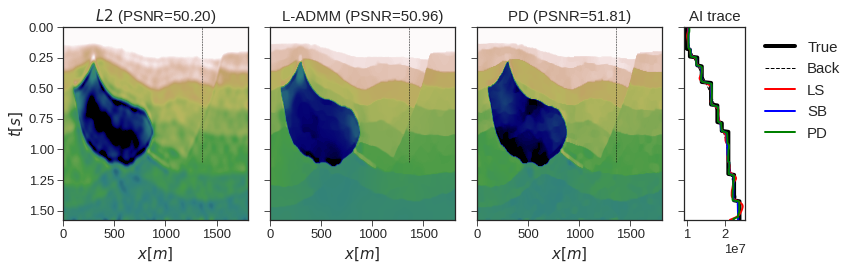

In [23]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 4),
                        gridspec_kw={'width_ratios': [3, 3, 3, 1]})
axs[0].imshow(np.exp(minv), vmin=1.2e7, vmax=2.9e7,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'$L2$ (PSNR=%.2f)' % psnr['L2'])
axs[1].imshow(np.exp(mladmm), vmin=1.2e7, vmax=2.9e7,
              cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('L-ADMM (PSNR=%.2f)' % psnr['LADMM'])
axs[1].axis('tight')
axs[2].imshow(np.exp(mpd), vmin=1.2e7, vmax=2.9e7,
              cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('PD (PSNR=%.2f)' % psnr['PD'])
axs[2].axis('tight')
axs[3].plot(np.exp(m[:, 3*nx//4]), t0, 'k', lw=4, label='True')
axs[3].plot(np.exp(mback[:, 3*nx//4]), t0, '--k', lw=1, label='Back')
axs[3].plot(np.exp(minv[:, 3*nx//4]), t0, 'r', lw=2, label='LS')
axs[3].plot(np.exp(mladmm[:, 3*nx//4]), t0, 'b', lw=2, label='SB')
axs[3].plot(np.exp(mpd[:, 3*nx//4]), t0, 'g', lw=2, label='PD')
axs[3].legend(bbox_to_anchor=(1.1, 1.))
axs[3].axis('tight')
axs[3].set_title('AI trace')
plt.tight_layout()
plt.savefig('Figs/Hesspartial_inversions.eps', dpi=150);

## 2D Post-stack segmentation

Let's start by taking one of our previous inversion results and use it as input to a segmentation algorithm

In [24]:
segpd, segpd_classes = \
    Segment(mpd, cl, 20., 0.2, niter=50, show=True, 
            kwargs_simplex=dict(engine='numba',  maxiter=10, call=False))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 50

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   6.35672e-01   0.000e+00   4.507e+02   1.112e+04       1.158e+04
     2   7.75211e-01   0.000e+00   5.089e+02   7.217e+03       7.726e+03
     3   9.10785e-01   0.000e+00   5.458e+02   5.611e+03       6.156e+03
     4   9.99411e-01   0.000e+00   5.606e+02   4.816e+03       5.377e+03
     5   9.98097e-01   0.000e+00   5.708e+02   4.490e+03       5.061e+03
     6   1.00175e+00   0.000e+00   5.820e+02   4.303e+03       4.885e+03
     7   1.00019e+00   0.000e+00   5.934e+02   4.163e+03       4.757e+03
     8

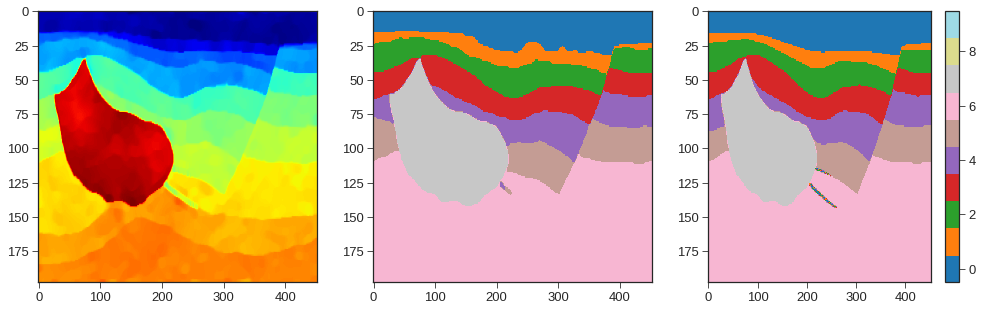

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].imshow(mpd, cmap='jet')
axs[0].axis('tight')
im=axs[1].imshow(segpd_classes, cmap=cm.get_cmap('tab20', nclall), vmin=-0.5, vmax=nclall-0.5)
axs[1].axis('tight')
im=axs[2].imshow(vcl_true.reshape(nt0, nx), cmap=cm.get_cmap('tab20', nclall), vmin=-0.5, vmax=nclall-0.5)
axs[2].axis('tight')
plt.colorbar(im);

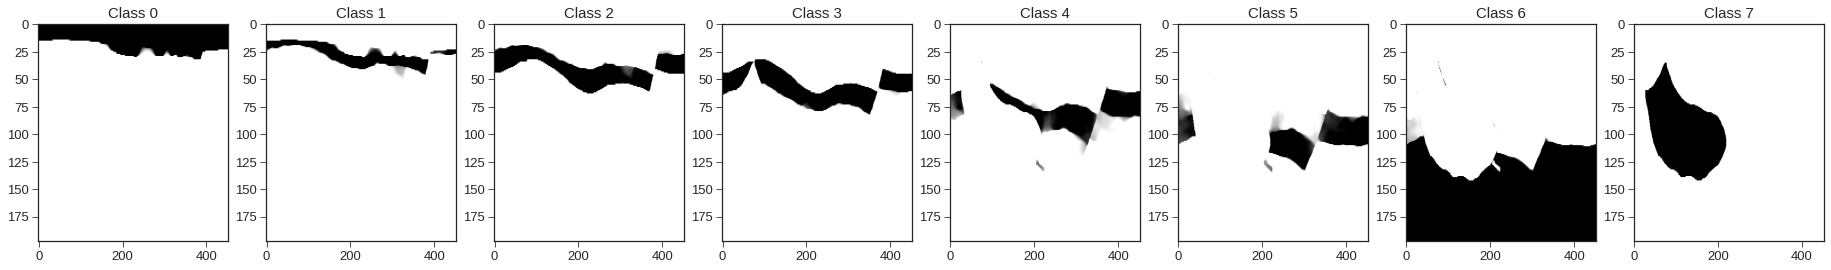

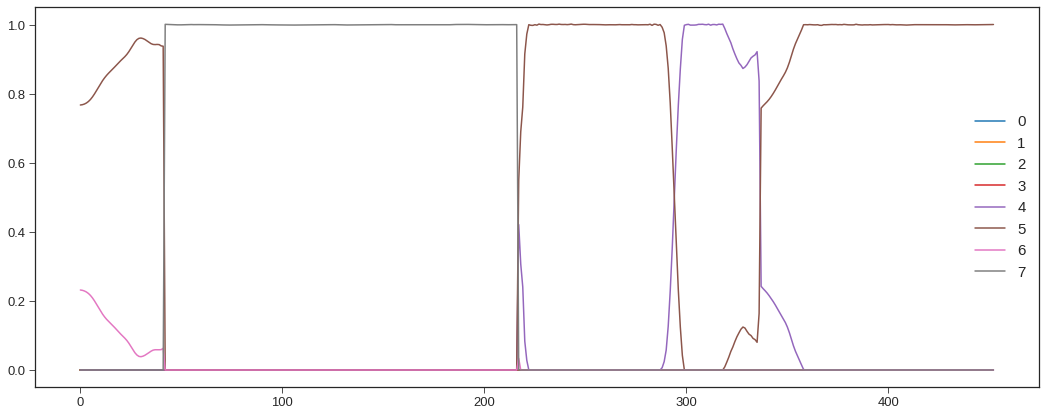

In [26]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
       
plt.figure(figsize=(18, 7))
for icl in range(ncl):
    plt.plot(segpd.reshape(nt0, nx, ncl)[100, :, icl], label=icl)
plt.legend();

### Extract horizons

In [27]:
horizon_list = multiclass_horizons(ncl, segpd_classes, 
                                   nn_lim=1, line_minlen=5, 
                                   verbose=False)

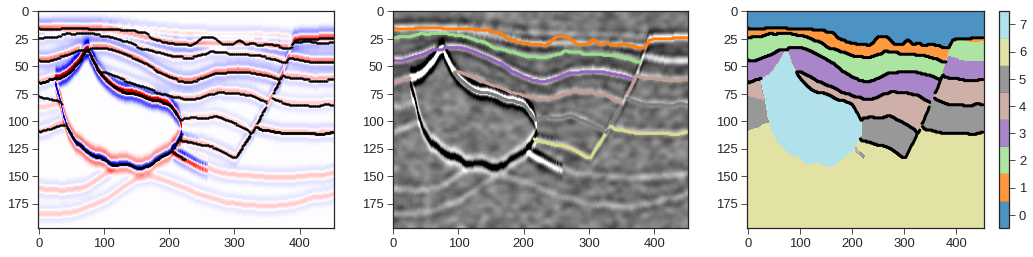

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
from matplotlib.colors import Normalize
norm = Normalize(vmin=-0.5, vmax=ncl-0.5)

ax1.imshow(d, vmin=-0.3, vmax=0.3, aspect="auto", cmap='seismic')
for i, h in horizon_list.iterrows():
    if h['chosen']:
        ax1.scatter(h['x'], h['y'], c='k', s=1)
ax1.axis('tight')

ax2.imshow(dn, vmin=-0.1, vmax=0.1, aspect="auto", cmap='gray')
for ihor, horkey in enumerate(hors.keys()):
    horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
    if len(horsel) > 0:
        ax2.plot(horsel[0]['regx'], horsel[0]['regy'], c=cm.get_cmap('tab20', ncl)(norm(ihor+1)), lw=3)

im=ax3.imshow(segpd_classes, aspect="auto", 
              cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5, alpha=0.8)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
        if len(horsel) > 0:
            ax3.plot(horsel[0]['regx'], horsel[0]['regy'], c='k', lw=3)
plt.colorbar(im, ax=ax3)
ax3.axis('tight');

In [29]:
segpd_classes[segpd_classes==ncl-1] = nclall-1 # change color

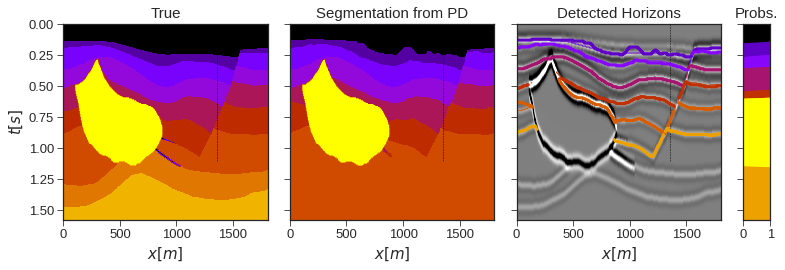

In [30]:
cmap_classes = 'gnuplot'
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(11, 4),
                        gridspec_kw={'width_ratios': [3, 3, 3, 0.4]})
axs[0].imshow(vcl_trueall, cmap=cm.get_cmap(cmap_classes, nclall), vmin=-0.5, vmax=nclall-0.5,
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title('True')
axs[1].imshow(segpd_classes, cmap=cm.get_cmap(cmap_classes, nclall), vmin=-0.5, vmax=nclall-0.5,
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Segmentation from PD')
axs[2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
axs[2].axis('tight')
for ihor, horkey in enumerate(hors.keys()):
    axs[2].plot(np.arange(nx) * dx, hors[horkey]* dt0, 
                c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=1)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
        for hsel in horsel:
            axs[2].plot(hsel['regx']* dx, hsel['regy']* dt0,
                        c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=3)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('Detected Horizons')

norm = Normalize(vmin=0, vmax=ncl)
probs = segpd.reshape(nt0, nx, ncl)[:, nx//3]
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((nt0, 1)), cdf))
for icl in range(ncl):
    axs[3].fill_betweenx(t0, cdf[:, icl], cdf[:, icl+1], 
                         color=cm.get_cmap(cmap_classes, ncl)(norm(icl)))
axs[3].set_xlim(0, 1)
axs[3].set_title('Probs.')
plt.tight_layout()
plt.savefig('Figs/Hesspartial_segmentation.eps', dpi=150);

## 2D Post-stack joint inversion & segmentation

**Inversion**

$$
m^{k+1} = min_x  (\frac{1}{2}||Ax-f||_2^2 + \delta ||\hat{V}x-\hat{c}||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

combining the first two terms

$$
m^{k+1} = min_x  (\frac{1}{2}||A^1x-f^1||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $A^1 = [A, \sqrt{2\delta}\hat{V}]^T$ and $f^1 = [f, \sqrt{2\delta}\hat{c}]^T$ and $\hat{V}=[diag(\sqrt{v_1}), ..., diag(\sqrt{v_N})]$ and $\hat{c}=[\sqrt{v_1}c_1, ..., \sqrt{v_N}c_N]$


**Segmentation**


$$
v^{k+1} = min_{v \in C}  (v^T(\delta g - \beta q^k) - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $C$ is a simplex.

Working with alpha=0.010000,  beta=0.100000,  delta=2.000000
Iteration 0...
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.237500e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.61196e+01   1.914e+01   6.993e+00   0.000e+00       2.614e+01
     2   1.61259e+01   9.430e+00   8.270e+00   0.000e+00       1.770e+01
     3   1.61337e+01   6.373e+00   8.728e+00   0.000e+00       1.510e+01
     4   1.61418e+01   5.003e+00   8.837e+00   0.000e+00       1.384e+01
     5   1.61492e+01   4.239e+00   8.808e+00   0.000e+00       1.305e+01
     6   1.61555e+01   3.757e+00   8.726e+00   0.000e+00       1.248e+01
     7   1.61605e+01   3.426e+00 

     1   5.09162e-01   0.000e+00   8.894e+01   7.540e+03       7.629e+03
     2   6.74569e-01   0.000e+00   1.054e+02   4.166e+03       4.271e+03
     3   7.61842e-01   0.000e+00   1.157e+02   3.063e+03       3.179e+03
     4   8.49105e-01   0.000e+00   1.225e+02   2.443e+03       2.566e+03
     5   9.36354e-01   0.000e+00   1.235e+02   2.025e+03       2.148e+03
     6   1.00015e+00   0.000e+00   1.236e+02   1.797e+03       1.921e+03
     7   1.00143e+00   0.000e+00   1.246e+02   1.667e+03       1.792e+03
     8   9.98774e-01   0.000e+00   1.262e+02   1.572e+03       1.698e+03
     9   9.99988e-01   0.000e+00   1.285e+02   1.491e+03       1.620e+03
    10   1.00139e+00   0.000e+00   1.307e+02   1.416e+03       1.547e+03
    11   9.98087e-01   0.000e+00   1.326e+02   1.344e+03       1.476e+03
    16   1.00179e+00   0.000e+00   1.358e+02   1.066e+03       1.202e+03
    21   1.00147e+00   0.000e+00   1.360e+02   9.556e+02       1.092e+03
    26   9.99023e-01   0.000e+00   1.366e+02   8.91

     9   1.61196e+01   2.096e+01   7.159e+00   0.000e+00       2.812e+01
    10   1.61196e+01   2.097e+01   7.132e+00   0.000e+00       2.810e+01
    11   1.61195e+01   2.098e+01   7.108e+00   0.000e+00       2.808e+01
    21   1.61191e+01   2.105e+01   6.942e+00   0.000e+00       2.799e+01
    31   1.61188e+01   2.109e+01   6.852e+00   0.000e+00       2.795e+01
    41   1.61185e+01   2.113e+01   6.798e+00   0.000e+00       2.792e+01
    51   1.61183e+01   2.115e+01   6.763e+00   0.000e+00       2.791e+01
    61   1.61182e+01   2.116e+01   6.740e+00   0.000e+00       2.790e+01
    71   1.61180e+01   2.117e+01   6.725e+00   0.000e+00       2.789e+01
    81   1.61179e+01   2.118e+01   6.715e+00   0.000e+00       2.789e+01
    91   1.61178e+01   2.118e+01   6.707e+00   0.000e+00       2.789e+01
    92   1.61178e+01   2.118e+01   6.707e+00   0.000e+00       2.789e+01
    93   1.61178e+01   2.118e+01   6.706e+00   0.000e+00       2.789e+01
    94   1.61178e+01   2.118e+01   6.706e+00   0.00

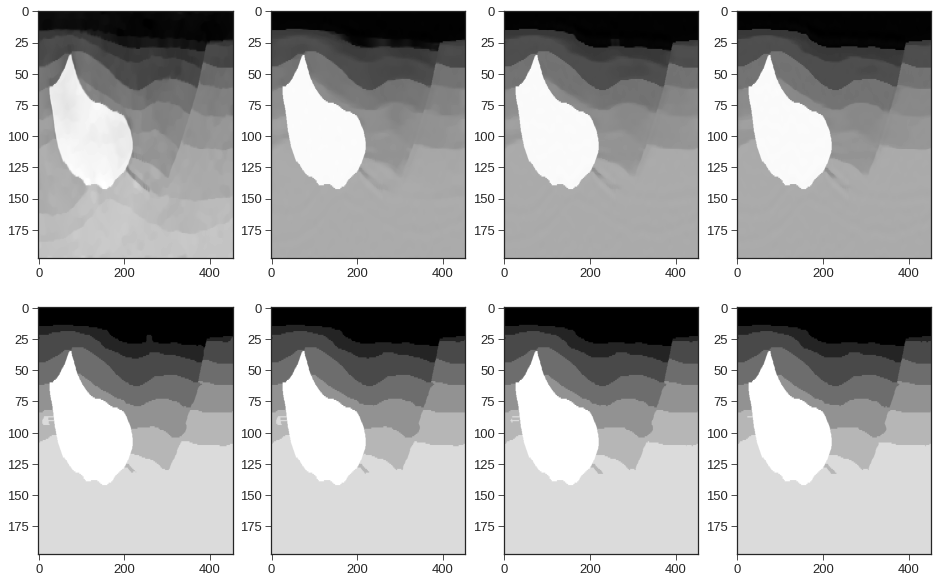

In [31]:
alpha = 0.01
beta = 0.1
delta = 2.

niter = 2
tolstop = 0.

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

mjoint, vjoint, vcljoint, rre, psnr, mjoint_hist, vjoint_hist = \
    joint_inversion_segmentation(dn, mback, cl, Lop, alpha, beta, delta, tau, mu,
                                 niter=4, l2niter=20, pdniter=100,
                                 segmentniter=50, bisectniter=10, tolstop=0.,
                                 mtrue=m, plotflag=True, show=True)

In [32]:
vcljoint[vcljoint==ncl-1] = nclall-1 # change color

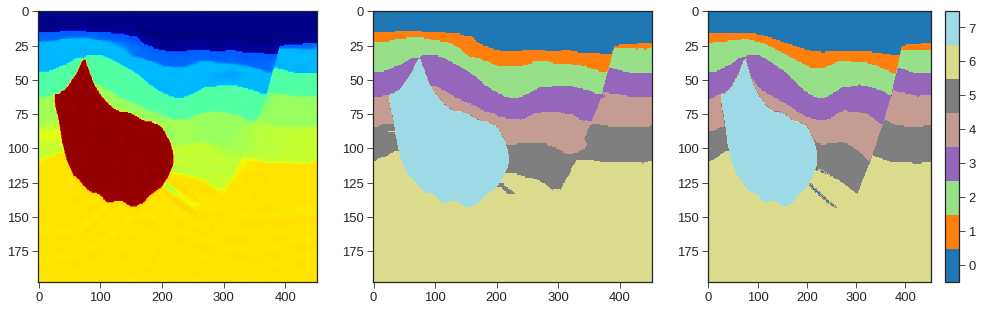

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].imshow(mjoint.reshape(nt0, nx), cmap='jet')
axs[0].axis('tight')
im=axs[1].imshow(vcljoint.reshape(nt0, nx), cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5)
axs[1].axis('tight');
im=axs[2].imshow(vcl_true.reshape(nt0, nx), cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5)
axs[2].axis('tight');
plt.colorbar(im);

[ 9999978. 12747960. 13921967. 16351979. 17993972. 19145972. 20859960.
 29599952.]


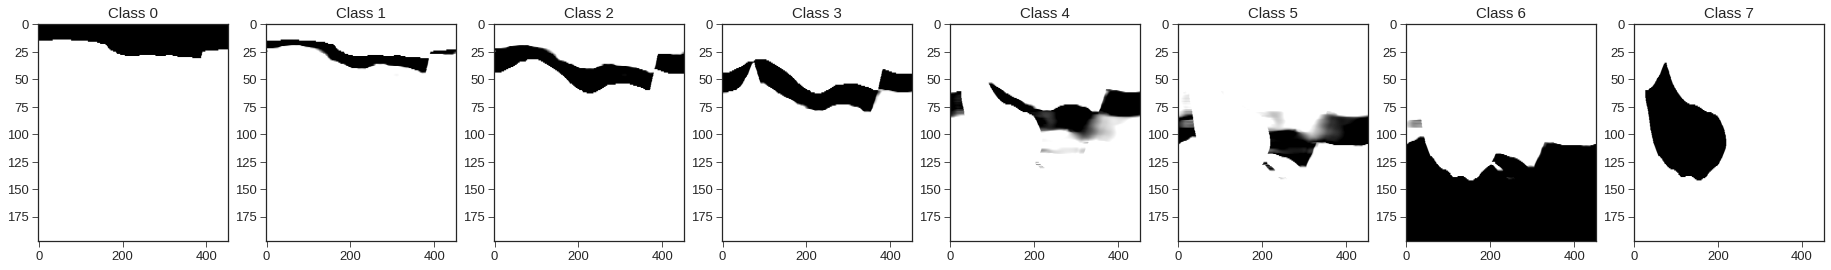

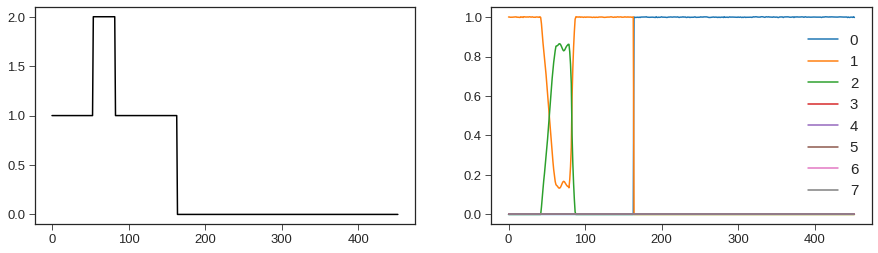

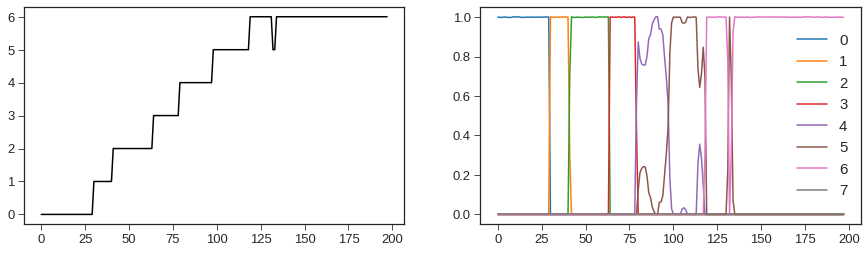

In [34]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(vjoint[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(vcljoint.reshape(nt0, nx)[20], 'k')
for icl in range(ncl):
    axs[1].plot(vjoint.reshape(nt0, nx, ncl)[20, :, icl], label=icl)
axs[1].legend(loc='right')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(vcljoint.reshape(nt0, nx)[:, nx//2], 'k')
for icl in range(ncl):
    axs[1].plot(vjoint.reshape(nt0, nx, ncl)[:, nx//2, icl], label=icl)
axs[1].legend(loc='right');

print(np.exp(cl))

In [43]:
horizon_list = multiclass_horizons(ncl-1, vcljoint.reshape(nt0, nx), 
                                   nn_lim=1, line_minlen=5, 
                                   verbose=True)

Class: 0
Start: 2021-02-28 15:17:24.731249
Compute TV Completed: 0:00:00.006175 sec
Get horizon points Completed: 0:00:00.000609 sec
Get separated horizons Completed: 0:00:02.548354 sec
Interpolate horizons Completed: 0:00:00.000888 sec
Label horizons Completed: 0:00:00.003795 sec
Join horizons Completed: 0:00:00.007762 sec
Regredding horizons Completed: 0:00:00.001519 sec
End: 2021-02-28 15:17:27.301012
Duration: 0:00:02.569763
 
Class: 1
Start: 2021-02-28 15:17:27.301060
Compute TV Completed: 0:00:00.004362 sec
Get horizon points Completed: 0:00:00.000365 sec
Get separated horizons Completed: 0:00:04.402590 sec
Interpolate horizons Completed: 0:00:00.000978 sec
Label horizons Completed: 0:00:00.003879 sec
Join horizons Completed: 0:00:00.007451 sec
Regredding horizons Completed: 0:00:00.002512 sec
End: 2021-02-28 15:17:31.723845
Duration: 0:00:04.422785
 
Class: 2
Start: 2021-02-28 15:17:31.723896
Compute TV Completed: 0:00:00.004405 sec
Get horizon points Completed: 0:00:00.000436 s

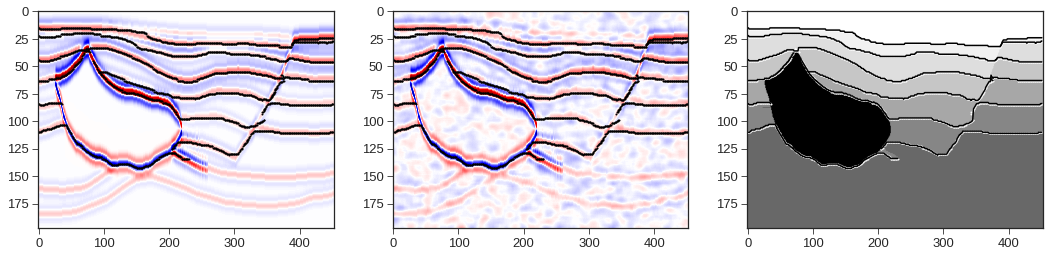

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.imshow(d, vmin=-0.3, vmax=0.3, aspect="auto", cmap='seismic')
for i, h in horizon_list.iterrows():
    if h['chosen']:
        ax1.scatter(h['x'], h['y'], c='k', s=1)
ax1.axis('tight')

ax2.imshow(dn, vmin=-0.3, vmax=0.3, aspect="auto", cmap='seismic')
for i, h in horizon_list.iterrows():
    if h['chosen']:
        ax2.scatter(h['x'], h['y'], c='k', s=1)
ax2.axis('tight')

ax3.imshow(vcljoint.reshape(nt0, nx), aspect="auto")
for i, h in horizon_list.iterrows():
    if h['chosen']:
        ax3.scatter(h['x'], h['y'], c='w', s=1)
        ax3.plot(h['regx'], h['regy'], c='k')
ax3.axis('tight');

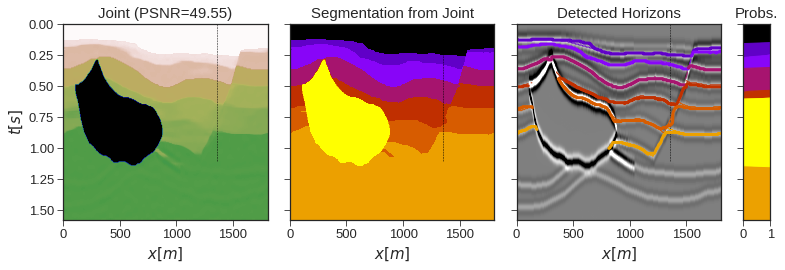

In [39]:
cmap_classes = 'gnuplot'
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(11, 4),
                        gridspec_kw={'width_ratios': [3, 3, 3, 0.4]})
axs[0].imshow(np.exp(mjoint).reshape(nt0, nx), vmin=1.2e7, vmax=2.9e7,
                   cmap='gist_earth_r', extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'Joint (PSNR=%.2f)' % psnr[-1])
axs[1].imshow(vcljoint.reshape(nt0, nx), cmap=cm.get_cmap(cmap_classes, ncl), vmin=-0.5, vmax=ncl-0.5,
              extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Segmentation from Joint')
axs[2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[3*nx//4], ymin=60/nt0, ymax=1, c='k', ls='--', lw=0.5)
axs[2].axis('tight')
for ihor, horkey in enumerate(hors.keys()):
    axs[2].plot(np.arange(nx) * dx, hors[horkey]* dt0, 
                c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=1)
for ihor, horkey in enumerate(hors.keys()):
        horsel = [h for i, h in horizon_list.iterrows() if h['chosen'] and h['h_id'] == horkey]
        for hsel in horsel:
            axs[2].plot(hsel['regx']* dx, hsel['regy']* dt0,
                        c=cm.get_cmap(cmap_classes, ncl)(norm(ihor+1)), lw=3)
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title('Detected Horizons')

norm = Normalize(vmin=0, vmax=ncl)
probs = vjoint.reshape(nt0, nx, ncl)[:, nx//3]
cdf = np.cumsum(probs, axis=1)
cdf = np.hstack((np.zeros((nt0, 1)), cdf))
for icl in range(ncl):
    axs[3].fill_betweenx(t0, cdf[:, icl], cdf[:, icl+1], 
                         color=cm.get_cmap(cmap_classes, ncl)(norm(icl)))
axs[3].set_xlim(0, 1)
axs[3].set_title('Probs.')
plt.tight_layout()
plt.savefig('Figs/Hesspartial_joint.eps', dpi=150);

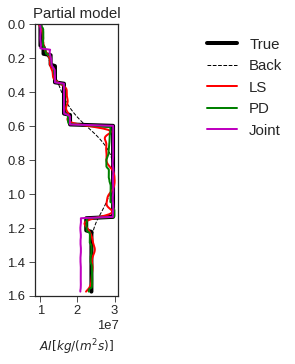

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 5))
ax.plot(np.exp(m[:, nx//3]), t0, 'k', lw=4, label='True')
ax.plot(np.exp(mback[:, nx//3]), t0, '--k', lw=1, label='Back')
ax.plot(np.exp(minv[:, nx//3]), t0, 'r', lw=2, label='LS')
ax.plot(np.exp(mpd[:, nx//3]), t0, 'g', lw=2, label='PD')
ax.plot(np.exp(mjoint).reshape(nt0, nx)[:, nx//3], t0, 'm', lw=2, label='Joint')
ax.set_xlabel(r'$AI [kg/(m^2s)]$', fontsize=12, labelpad=20.)
#ax.set_ylabel('t[s]')
ax.set_title('Partial model')
ax.set_ylim(1.6, 0)
ax.legend(bbox_to_anchor=(1.9, 1.))
plt.savefig('Figs/Hesspartial_traces.eps', dpi=150, bbox_inches='tight');